# NEU-Regression: Simulation Experiments
---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:
- Load Dependancies,
- Makes Paths if missing.

In [89]:
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# Load Hyper( and meta) parameter(s)
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
%run Architecture_Builder.ipynb
# exec(open('Architecture_Builder.py').read())

Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


# Generate Training Data

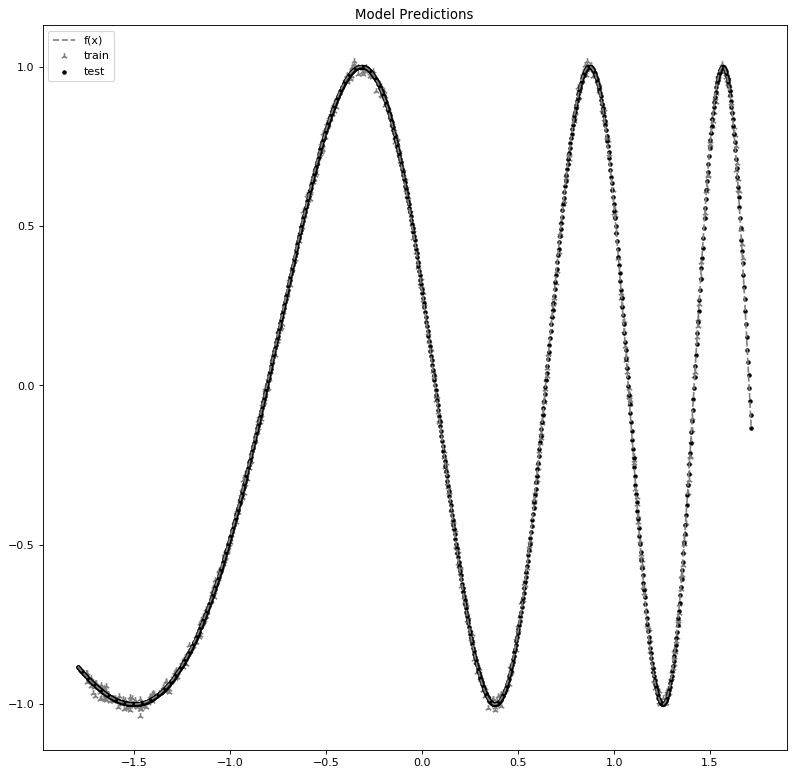

In [90]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
Option_Function = "oscilatory"
%run Data_Generator.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [24]:
if False:#os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    tf.random.set_seed(2020)
    ffNN_y_hat_train,ffNN_y_hat_test = build_ffNN(n_folds = CV_folds, 
                                                 n_jobs = n_jobs, 
                                                 n_iter = n_iter, 
                                                 param_grid_in = param_grid_Vanilla_Nets, 
                                                 X_train = data_x, 
                                                 y_train = data_y,
                                                 X_test = data_x_test)

Pre-trained benchmark model does not exist: Training.
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished


Epoch 1/50
47/47 [==============================] - 0s 1ms/step - loss: 0.7045 - mse: 0.7258 - mae: 0.7045 - mape: 134.6908
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6825 - mse: 0.7030 - mae: 0.6825 - mape: 140.6892
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6797 - mse: 0.7073 - mae: 0.6797 - mape: 149.8724
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6767 - mse: 0.6962 - mae: 0.6767 - mape: 145.7150
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6739 - mse: 0.6890 - mae: 0.6739 - mape: 141.7891
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6773 - mse: 0.6974 - mae: 0.6773 - mape: 152.2508
Epoch 7/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6741 - mse: 0.6826 - mae: 0.6741 - mape: 136.8043
Epoch 8/50
47/47 [==============================] - 0s 2ms/step - loss: 0.6681 - mse: 0.6853 - mae: 0.6681 - mape: 149.9169
Epoch 9/

# Train NEU-OLS

### 1 + 2) Learn Linearizing Feature map and Train OLS

In [91]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS = build_NEU_OLS(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,NEU_OLS_y_hat_train_pre.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,NEU_OLS_y_hat_test_pre.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   40.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   40.0s finished


Epoch 1/50
47/47 [==============================] - 0s 9ms/step - loss: 0.7700 - mse: 0.8309 - mae: 0.7677 - mape: 150.9055
Epoch 2/50
47/47 [==============================] - 0s 8ms/step - loss: 0.6922 - mse: 0.5957 - mae: 0.6911 - mape: 116.7023
Epoch 3/50
47/47 [==============================] - 0s 8ms/step - loss: 0.6760 - mse: 0.5539 - mae: 0.6750 - mape: 105.1501
Epoch 4/50
47/47 [==============================] - 0s 8ms/step - loss: 0.6666 - mse: 0.5373 - mae: 0.6657 - mape: 101.6434
Epoch 5/50
47/47 [==============================] - 0s 9ms/step - loss: 0.6590 - mse: 0.5275 - mae: 0.6581 - mape: 100.9631
Epoch 6/50
47/47 [==============================] - 0s 9ms/step - loss: 0.6535 - mse: 0.5241 - mae: 0.6526 - mape: 104.7423
Epoch 7/50
47/47 [==============================] - 0s 9ms/step - loss: 0.6486 - mse: 0.5213 - mae: 0.6477 - mape: 107.9314
Epoch 8/50
47/47 [==============================] - 0s 9ms/step - loss: 0.6452 - mse: 0.5169 - mae: 0.6443 - mape: 110.6516
Epoch 9/

In [92]:
lin_reg = LinearRegression()
lin_reg.fit(data_x,data_y)
OLS_y_hat_train = lin_reg.predict(data_x)
OLS_y_hat_test = lin_reg.predict(data_x_test)

# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train,data_y)
NEU_OLS_Internal = NEU_lin_reg.predict(data_x_featured_test)

In [93]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = lin_reg.predict(data_x_featured_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_OLS_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_OLS_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
#========================#
NEU_OLS_y_hat_train, NEU_OLS_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   17.9s finished


Epoch 1/50
47/47 [==============================] - 0s 5ms/step - loss: 0.6629 - mse: 0.5408 - mae: 0.6619 - mape: 101.0006
Epoch 2/50
47/47 [==============================] - 0s 5ms/step - loss: 0.6527 - mse: 0.5217 - mae: 0.6518 - mape: 102.0517
Epoch 3/50
47/47 [==============================] - 0s 5ms/step - loss: 0.6429 - mse: 0.5096 - mae: 0.6420 - mape: 101.0455
Epoch 4/50
47/47 [==============================] - 0s 6ms/step - loss: 0.6725 - mse: 0.5688 - mae: 0.6714 - mape: 107.1356
Epoch 5/50
47/47 [==============================] - 0s 5ms/step - loss: 0.6539 - mse: 0.5263 - mae: 0.6529 - mape: 109.4020
Epoch 6/50
47/47 [==============================] - 0s 5ms/step - loss: 0.6573 - mse: 0.5344 - mae: 0.6564 - mape: 113.0809
Epoch 7/50
47/47 [==============================] - 0s 6ms/step - loss: 0.6567 - mse: 0.5350 - mae: 0.6557 - mape: 113.4570
Epoch 8/50
47/47 [==============================] - 0s 5ms/step - loss: 0.6620 - mse: 0.5532 - mae: 0.6609 - mape: 117.2495
Epoch 9/

### 3) Learn Structure Map

# Train NEU-ffNN

#### Fully-Coupled Implementation

In [42]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   13.3s finished


Epoch 1/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7199 - mse: 0.7414 - mae: 0.7178 - mape: 118.9500
Epoch 2/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7078 - mse: 0.7294 - mae: 0.7056 - mape: 127.8092
Epoch 3/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7055 - mse: 0.7311 - mae: 0.7033 - mape: 133.0611
Epoch 4/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7063 - mse: 0.7297 - mae: 0.7040 - mape: 132.6393
Epoch 5/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7037 - mse: 0.7226 - mae: 0.7016 - mape: 127.0970
Epoch 6/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7045 - mse: 0.7324 - mae: 0.7022 - mape: 132.9442
Epoch 7/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7009 - mse: 0.7173 - mae: 0.6988 - mape: 128.2861
Epoch 8/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6995 - mse: 0.7205 - mae: 0.6973 - mape: 131.8408
Epoch 9/

#### Fully-Coupled Implementation

In [43]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Completed Above
print("Phase 1 Complete: Feature Map Trained/Loaded")

# 2) Train ffNN #
#===============#
NEU_ffNN_y_hat_train_dcpld, NEU_ffNN_y_hat_test_dcpld = build_ffNN(n_folds = CV_folds, 
                                                                   n_jobs = n_jobs, 
                                                                   n_iter = n_iter, 
                                                                   param_grid_in = param_grid_Vanilla_Nets,  
                                                                   X_train = data_x_NEU_train_feature_only, 
                                                                   y_train = data_y,
                                                                   X_test = data_x_NEU_test_feature_only)
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_ffNN_y_hat_train_dcpld.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_ffNN_y_hat_test_dcpld.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Update User #
#-------------#
print("Phase 2 Complete: Trained Vanilla Model")

# 3) Learn Structure Map #
#========================#
NEU_ffNN_y_hat_train_Dcpld, NEU_ffNN_y_hat_test_Dcpld = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train_scaled, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test_scaled)

# Update User #
#-------------#
print("Phase 3 Complete: Trained NEU-Structure Map")
print("NEU Statue: Trained")

Phase 1 Complete: Feature Map Trained/Loaded
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.8s finished


Epoch 1/50
47/47 [==============================] - 0s 1ms/step - loss: 0.7356 - mse: 0.7735 - mae: 0.7356 - mape: 121.8727
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7273 - mse: 0.7562 - mae: 0.7273 - mape: 118.9008
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7266 - mse: 0.7595 - mae: 0.7266 - mape: 120.3839
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7268 - mse: 0.7619 - mae: 0.7268 - mape: 129.6926
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7251 - mse: 0.7568 - mae: 0.7251 - mape: 127.7068
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7278 - mse: 0.7627 - mae: 0.7278 - mape: 126.9810
Epoch 7/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7257 - mse: 0.7562 - mae: 0.7257 - mape: 122.2317
Epoch 8/50
47/47 [==============================] - 0s 2ms/step - loss: 0.7280 - mse: 0.7642 - mae: 0.7280 - mape: 131.9480
Epoch 9/

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   12.5s finished


Epoch 1/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7492 - mse: 0.7801 - mae: 0.7472 - mape: 120.1112
Epoch 2/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7468 - mse: 0.7757 - mae: 0.7446 - mape: 116.9460
Epoch 3/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7445 - mse: 0.7721 - mae: 0.7424 - mape: 111.6180
Epoch 4/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7425 - mse: 0.7696 - mae: 0.7404 - mape: 111.0328
Epoch 5/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7405 - mse: 0.7660 - mae: 0.7384 - mape: 109.9406
Epoch 6/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7392 - mse: 0.7658 - mae: 0.7371 - mape: 108.5033
Epoch 7/50
47/47 [==============================] - 0s 4ms/step - loss: 0.7375 - mse: 0.7633 - mae: 0.7355 - mape: 108.9038
Epoch 8/50
47/47 [==============================] - 0s 3ms/step - loss: 0.7365 - mse: 0.7618 - mae: 0.7344 - mape: 111.3351
Epoch 9/

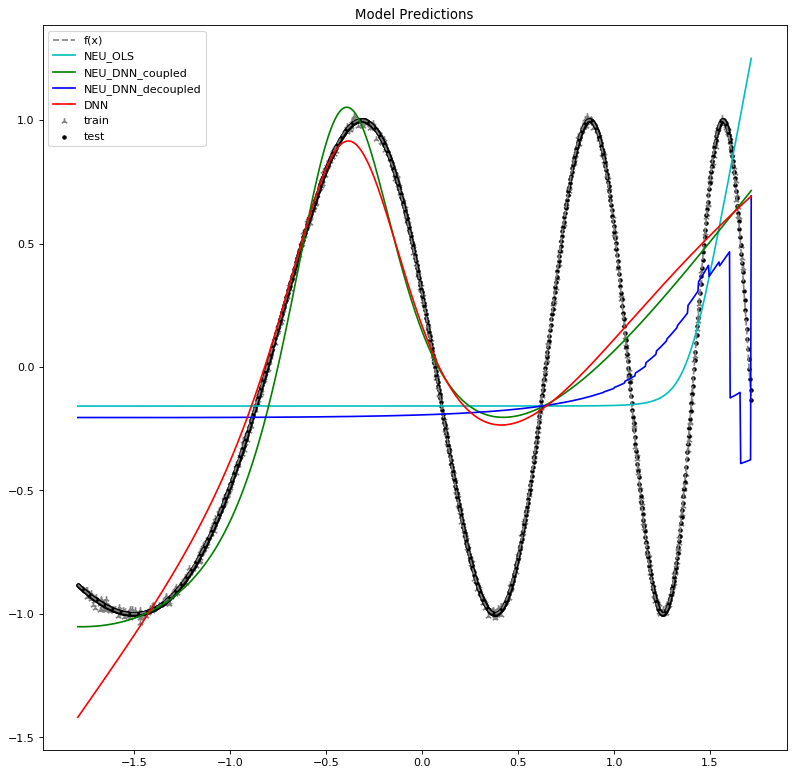

In [94]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test).reshape(-1,),NEU_OLS_Internal, color = 'c',label='NEU_OLS')
# # Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test, color = 'green',label='NEU_DNN_coupled')
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test_Dcpld, color = 'blue',label='NEU_DNN_decoupled')

plt.plot(np.array(data_x_test).reshape(-1,),ffNN_y_hat_test, color = 'red',label='DNN')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

Run univariate regression benchmarks file:

In [55]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

# Visualize Predictions

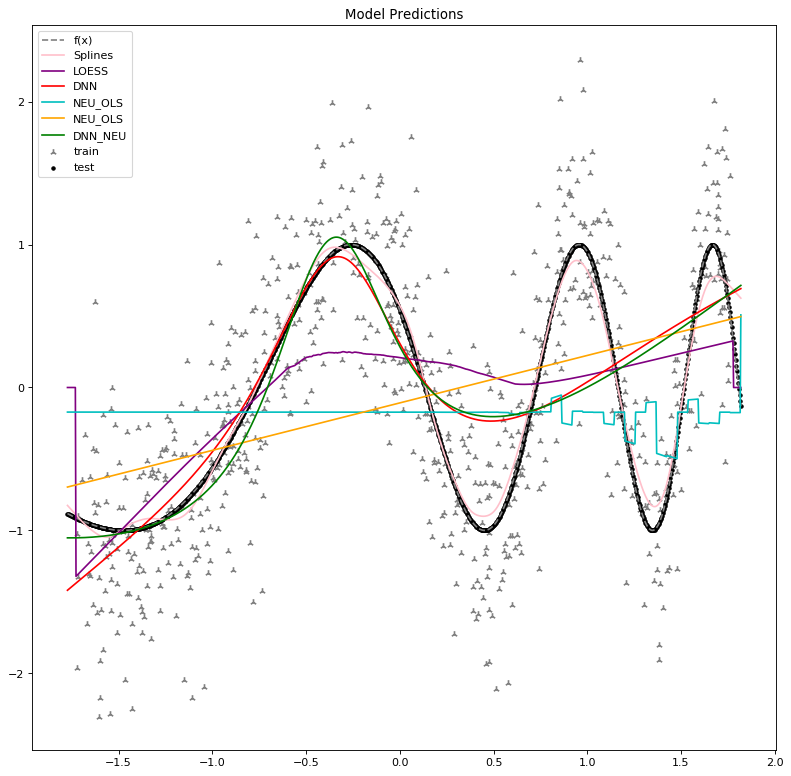

In [87]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# Plot Benchmark(s): DNNs
plt.plot(np.array(data_x_test).reshape(-1,),ffNN_y_hat_test, color = 'red', label='DNN')

#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU_OLS')
plt.plot(np.array(data_x_test).reshape(-1,),OLS_y_hat_test, color = 'orange',label='NEU_OLS')
# # Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test, color = 'green',label='DNN_NEU')
# plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test_dcpld2, color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

## Performance Report

In [68]:
#--------------------#
# Classical Model(s) #
#--------------------#
# NEU-OLS Performance
print("OLS-Performance:")
print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

OLS-Performance:
           train        test
MAE     0.684702    0.591299
MSE     0.697649    0.461089
MAPE  747.230454  899.938057
NEU-OLS-Performance:
            train        test
MAE      0.760189    0.681438
MSE      0.823454    0.593099
MAPE  3209.504193  785.795937


In [69]:
# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

Splines-Performance:
           train       test
MAE     0.399573   0.071204
MSE     0.250669   0.010806
MAPE  114.728474  16.977748
LOESS Performance:
           train      test
MAE     0.598057  0.473265
MSE     0.546299  0.333076
MAPE  531.118849       inf


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [48]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN Performance:")
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))

ffNN-Performance:
           train        test
MAE     0.528730    0.339704
MSE     0.448433    0.233781
MAPE  643.041827  550.627028
NEU-ffNN Performance:
           train        test
MAE     0.525934    0.331828
MSE     0.443546    0.226611
MAPE  475.080426  600.840864


#### The END

---